In [1]:
import torch
import torch.optim as optim
from torchvision.utils import save_image
import numpy as np
import json

import sys
sys.path.append("..")
from src.datamodules.co3d.dataset.dataloader_zoo import dataloader_zoo
from src.datamodules.co3d.dataset.dataset_zoo import dataset_zoo
from src.utils.rendering import *
from src.utils.utils import *
from src.utils.proj_ray_distance import *

In [2]:
# 데이터셋 불러오기

category = "teddybear"
task = "singlesequence"
single_sequence_id = 0      # 0 또는 1

datasets = dataset_zoo(
        category=category,
        assert_single_seq=task == "singlesequence",
        dataset_name=f"co3d_{task}",
        test_on_train=False,
        load_point_clouds=False,
        test_restrict_sequence_id=single_sequence_id,
    )

Loading Co3D frames from /home/kmuvcl/dataset/CO3D/teddybear/frame_annotations.jgz.
Loading Co3D sequences from /home/kmuvcl/dataset/CO3D/teddybear/sequence_annotations.jgz.
Loading Co3D subset lists from /home/kmuvcl/dataset/CO3D/teddybear/set_lists.json.
Removing images with empty masks.
... filtered 72865 -> 63135
Limitting Co3D dataset to the '['test_known']' subsets.
pick_sequence: ['34_1479_4753']
... filtered 75 -> 1
CO3D Dataset #frames=81
Loading Co3D frames from /home/kmuvcl/dataset/CO3D/teddybear/frame_annotations.jgz.
Loading Co3D sequences from /home/kmuvcl/dataset/CO3D/teddybear/sequence_annotations.jgz.
Loading Co3D subset lists from /home/kmuvcl/dataset/CO3D/teddybear/set_lists.json.
Removing images with empty masks.
... filtered 72865 -> 63135
Limitting Co3D dataset to the '['test_known', 'test_unseen']' subsets.
pick_sequence: ['34_1479_4753']
... filtered 75 -> 1
CO3D Dataset #frames=102
Loading Co3D frames from /home/kmuvcl/dataset/CO3D/teddybear/frame_annotations.j

In [237]:
batch_size = 5
batch_num_per_seq = 10

dataloaders = dataloader_zoo(
        datasets,
        batch_size=batch_size,
        dataset_name=f"co3d_multisequence",
        images_per_seq_options=[batch_size * batch_num_per_seq],
    )

train_loader = dataloaders["train"]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([5, 800, 800, 3])


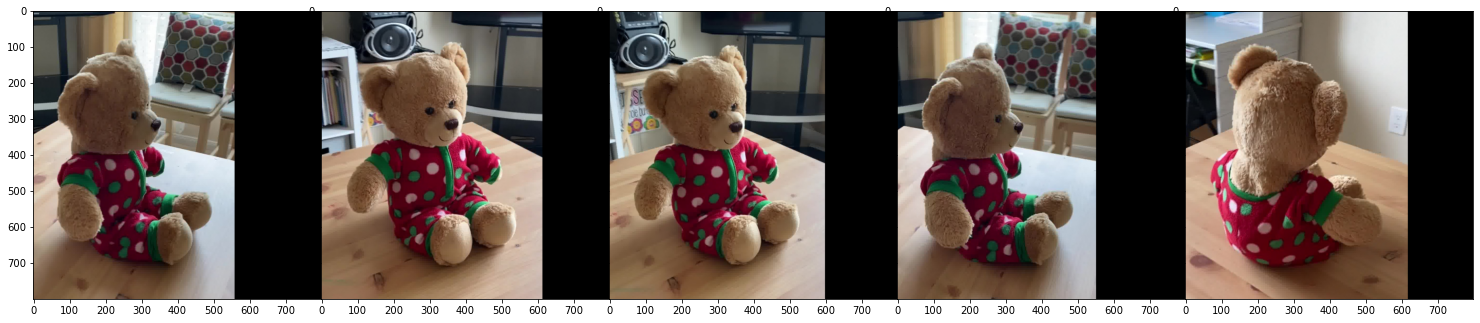

In [283]:
# data frame 하나 불러오기

data_frame = next(iter(train_loader))

imgs = data_frame.image_rgb.permute(0, 2, 3, 1)
cams = data_frame.camera
noise_cams = make_noise_camera(cams, rot_noise_factor=0.025, trans_noise_factor=0.05)

print(imgs.shape)

plt.figure(figsize=(20, 4))
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)

for i in range(0, 5):
    plt.subplot(1, 5, i+1)
    plt.imshow(imgs[i])

In [326]:
img_choices = imgs[:4]
cam_choices = PerspectiveCameras(
                                    focal_length=cams.focal_length[:4],
                                    principal_point=cams.principal_point[:4],
                                    R=cams.R[:4],
                                    T=cams.T[:4],
                                ).to(cams.device)
noise_cam_choices = make_noise_camera(cam_choices, rot_noise_factor=0.025, trans_noise_factor=0.05)

/home/kmuvcl/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/kmuvcl/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/kmuvcl/NVS/FastNeRFormer/notebook/../src/utils/utils.py:188: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


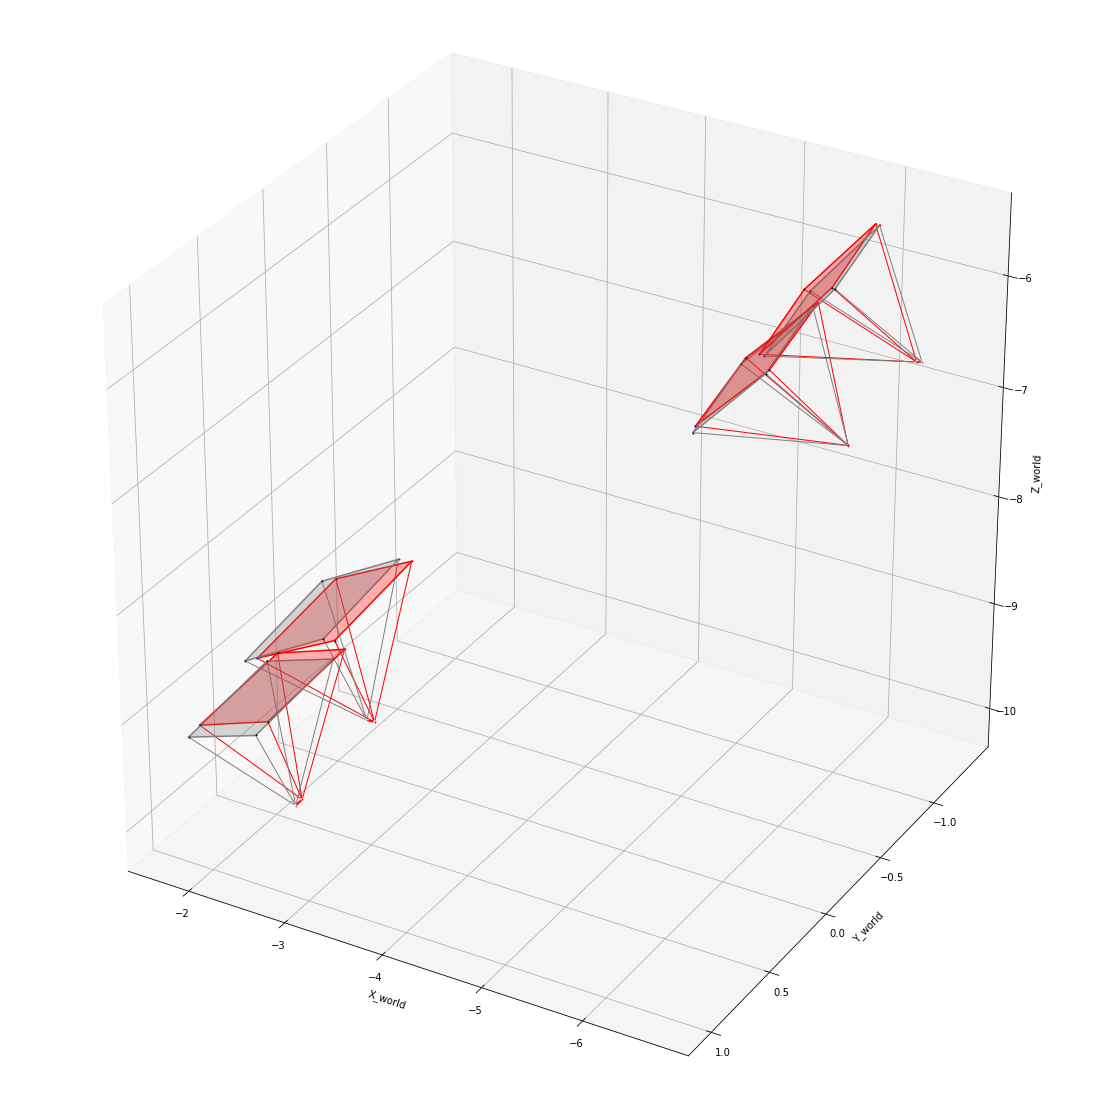

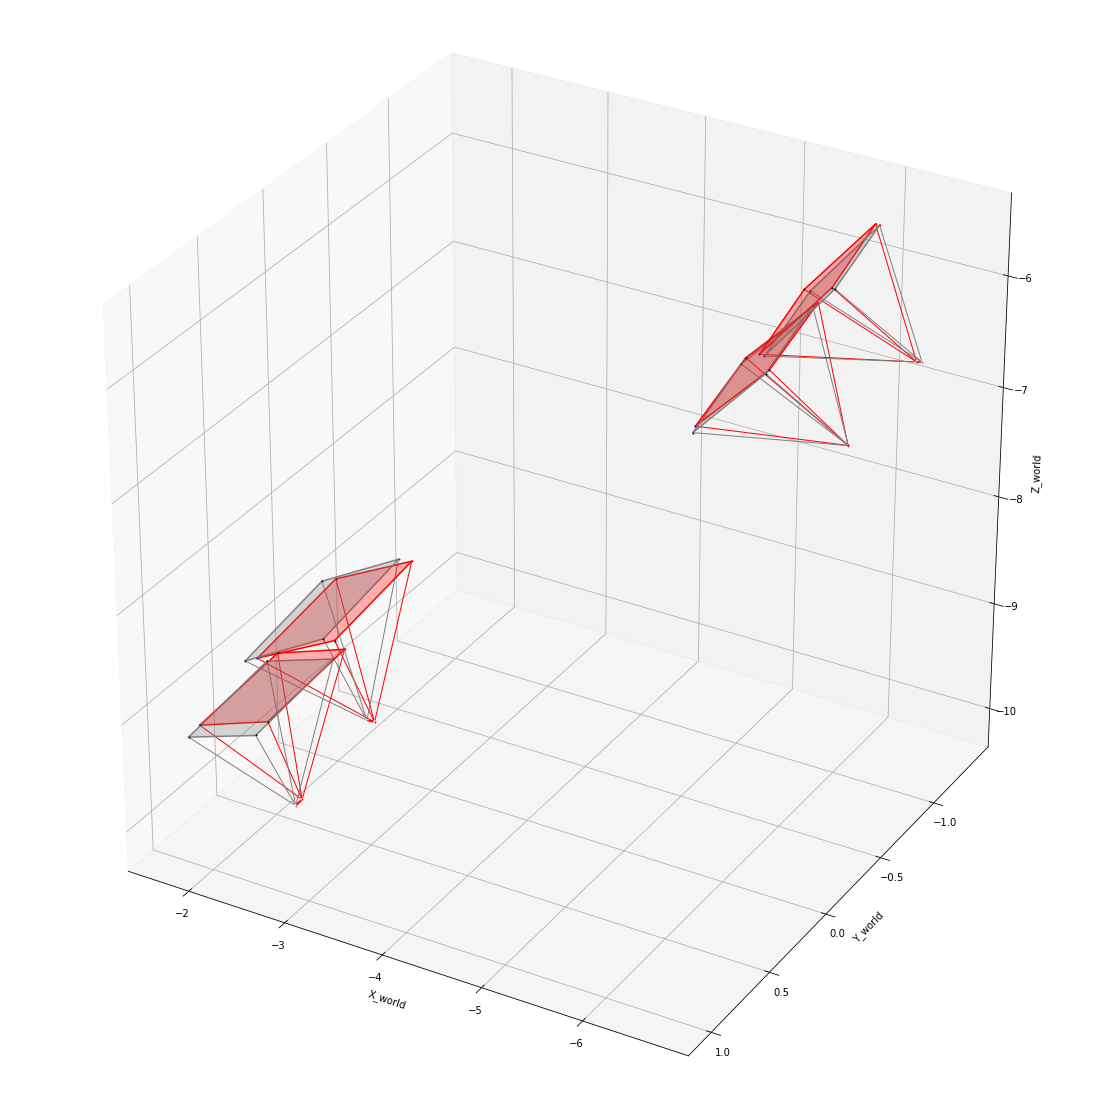

In [327]:
get_noise_camera_figure(cam_choices, [noise_cam_choices], draw_in_one_figure=True)

[<Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>]

/home/kmuvcl/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/kmuvcl/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/kmuvcl/NVS/FastNeRFormer/notebook/../src/utils/utils.py:188: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


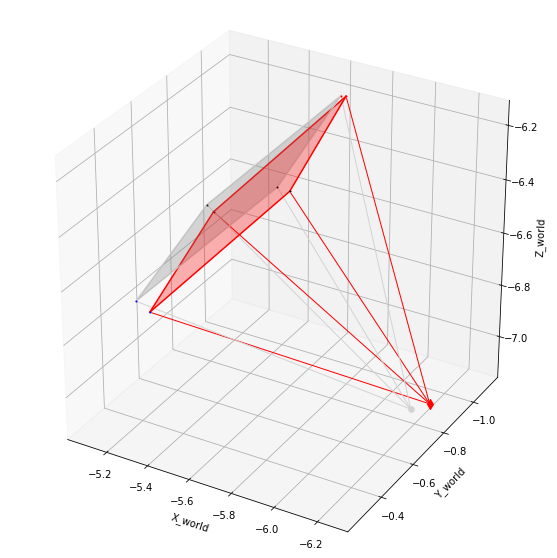

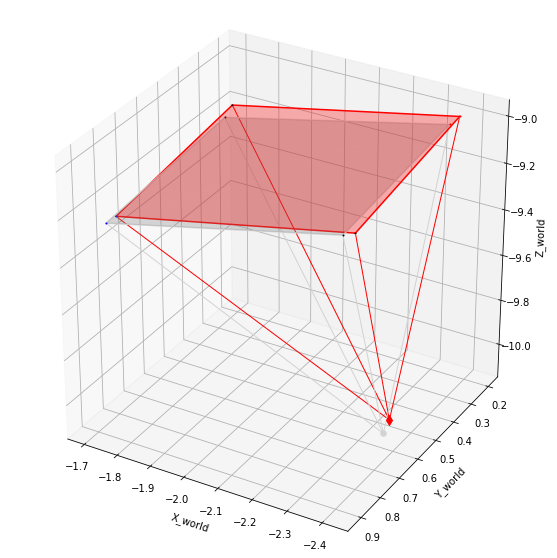

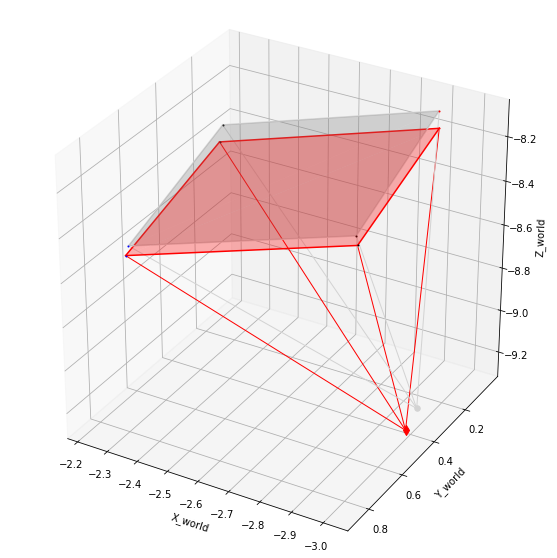

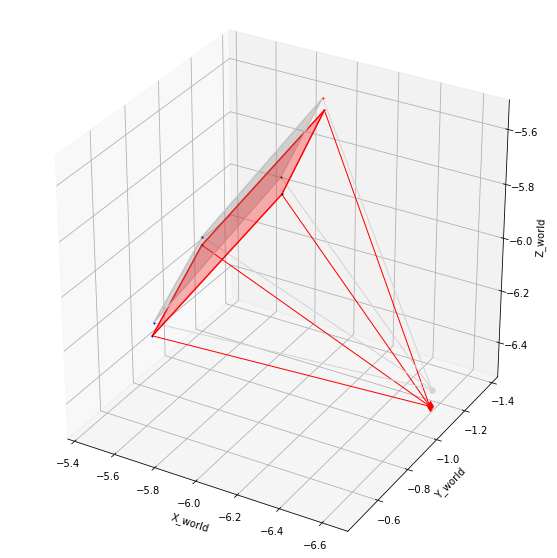

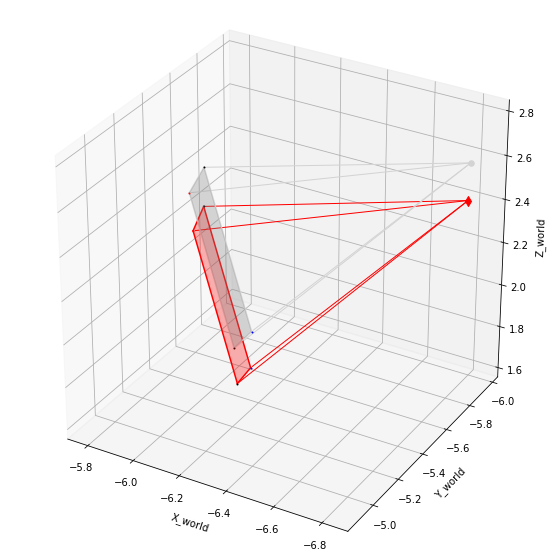

In [285]:
get_noise_camera_figure(cams, [noise_cams], draw_in_one_figure=False)

In [7]:
# Super-glue
matcher = init_superglue(0)

Loaded SuperPoint model
Loaded SuperGlue model ("outdoor" weights)


In [328]:
correspondences = {}

for i in range(0, 4):
    # 각 이미지 저장
    save_image(img_choices[i].permute(2, 0, 1), "img%d.png"%(i+1))
    
    for j in range(i+1, 4):
        img1 = img_choices[i]
        img2 = img_choices[j]
        
        # Correspondences 추출
        result = runSuperGlueSinglePair(matcher, img1, img2, 0)
        result = preprocess_match(result)
        
        pair = "(%d, %d)"%(i, j)
        
        if result[0] == None or result[1] == None:
            print("%s : No correspondences."%pair)
            correspondences[pair] = None
        else:
            print("%s :"%pair, result.shape)
            correspondences[pair] = {}
            
            img_i_points = result[0]
            img_j_points = result[1]
            
            correspondences[pair]["i"] = img_i_points.cpu().tolist()
            correspondences[pair]["j"] = img_j_points.cpu().tolist()
                

(0, 1) : torch.Size([2, 122, 2])
(0, 2) : torch.Size([2, 187, 2])
(0, 3) : torch.Size([2, 353, 2])
(1, 2) : torch.Size([2, 363, 2])
(1, 3) : torch.Size([2, 114, 2])
(2, 3) : torch.Size([2, 137, 2])


In [301]:
visualize_idxs = [(1, 4), (3, 4)]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


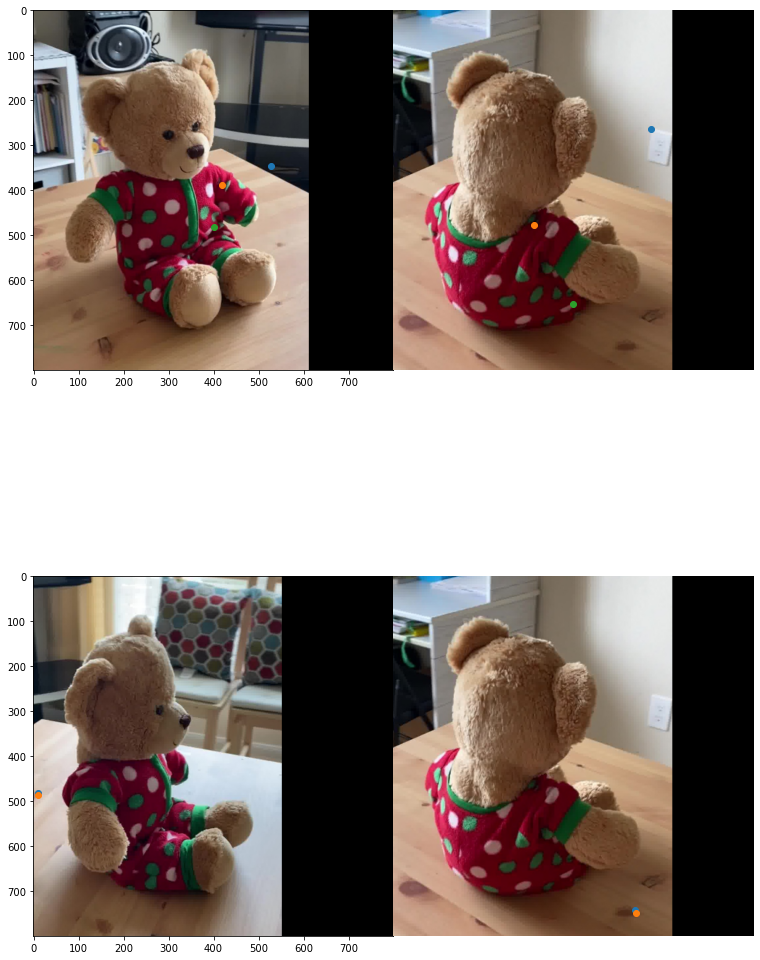

In [302]:
plt.figure(figsize=(10, 15))
plt.subplots_adjust(wspace=0, hspace=0.1, left=0, right=1, bottom=0, top=1)

row = 1
for (i, j) in visualize_idxs:
    keypoints = correspondences["(%d, %d)"%(i, j)]
    if keypoints == None:
        row + 1
        continue
    keypoints_i = keypoints['i']
    keypoints_j = keypoints['j']
    plt.subplot(len(visualize_idxs), 2, 2*row - 1)
    plt.imshow(imgs[i])
    
    plt.subplot(len(visualize_idxs), 2, 2*row)
    plt.axis("off")
    plt.imshow(imgs[j])
    
    for keypoint_idx in range(0, len(keypoints_i)):
        i_x, i_y = keypoints_i[keypoint_idx]
        j_x, j_y = keypoints_j[keypoint_idx]

        plt.subplot(len(visualize_idxs), 2, 2*row - 1)
        plt.scatter(i_x, i_y)
        
        plt.subplot(len(visualize_idxs), 2, 2*row)
        plt.scatter(j_x, j_y)
    row += 1

In [308]:
for (i, j) in visualize_idxs:
    correspondences["(%d, %d)"%(i, j)] = None

for i in range(0, 5):
    for j in range(i+1, 5):
        pair = "(%d, %d)"%(i, j)
        
        if correspondences[pair] == None:
            print(pair," : None.")
        else:
            print(pair, " : ", len(correspondences[pair]['i']))

(0, 1)  :  122
(0, 2)  :  187
(0, 3)  :  353
(0, 4)  : None.
(1, 2)  :  363
(1, 3)  :  114
(1, 4)  : None.
(2, 3)  :  137
(2, 4)  : None.
(3, 4)  : None.


In [7]:
print(correspondences.keys())

# 1번 이미지와 3번 이미지 페어
print(correspondences["(0, 2)"].keys())
# 위 페어에 대한 키포인트 중, 1번 이미지에서의 키포인트 (x, y)
print(correspondences["(0, 2)"]['i'])

dict_keys(['(0, 1)', '(0, 2)', '(0, 3)', '(0, 4)', '(1, 2)', '(1, 3)', '(1, 4)', '(2, 3)', '(2, 4)', '(3, 4)'])
dict_keys(['i', 'j'])
[[181.0, 588.0], [140.0, 723.0], [268.0, 735.0], [250.0, 701.0], [224.0, 595.0], [179.0, 632.0], [257.0, 461.0], [195.0, 635.0], [169.0, 565.0], [147.0, 527.0], [534.0, 537.0], [252.0, 445.0], [263.0, 640.0], [271.0, 486.0], [246.0, 493.0], [223.0, 580.0], [446.0, 277.0], [388.0, 626.0], [270.0, 212.0], [260.0, 617.0], [386.0, 647.0], [181.0, 719.0], [230.0, 542.0], [551.0, 522.0], [193.0, 578.0], [232.0, 769.0], [334.0, 558.0], [273.0, 180.0], [192.0, 616.0], [246.0, 662.0], [232.0, 475.0], [226.0, 522.0], [307.0, 176.0], [225.0, 781.0], [363.0, 692.0], [197.0, 762.0], [195.0, 768.0], [401.0, 323.0], [187.0, 755.0], [297.0, 514.0], [204.0, 652.0], [403.0, 179.0], [358.0, 636.0], [428.0, 266.0], [158.0, 713.0], [325.0, 405.0], [113.0, 560.0], [250.0, 526.0], [299.0, 490.0], [205.0, 569.0], [164.0, 486.0], [280.0, 538.0], [294.0, 581.0], [116.0, 532.0], [

In [108]:
# 전체 Correspondence 쌍들을 저장

with open('./correspondences.json','w') as f:
    json.dump(correspondences, f)

In [153]:
cam_info = {}
cam_info['R'] = cams.R.tolist()
cam_info['T'] = cams.T.tolist()
cam_info["focal_length"] = cams.focal_length.tolist()
cam_info["principal"] = cams.principal_point.tolist()

# 카메라 정보 저장
with open('./cameras.json','w') as f:
    json.dump(cam_info, f)

In [ ]:
# tmp_camera = PerspectiveCameras(
#                                 focal_length=cam_info["focal_length"],
#                                 principal_point=cam_info["principal"],
#                                 R=cam_info["R"],
#                                 T=cam_info["T"],
#                             )

In [132]:
def data_to_frame_test(co3d_data, N_src, rot_noise_factor=0.025, trans_noise_factor=0.05):
    imgs = co3d_data.image_rgb
    masks = co3d_data.fg_probability
    camera = co3d_data.camera

    c2ws = camera.get_world_to_view_transform().inverse().get_matrix()
    tgt_idx = 0
    tgt_c2w = c2ws[tgt_idx]
    src_c2ws = c2ws[1:]
    src_idxs = get_nearest_src(tgt_c2w, src_c2ws, N_src) + 1

    target = {}
    target["rgb"] = imgs[tgt_idx]
    target["mask"] = masks[tgt_idx]
    tgt_principal_point = camera.principal_point[tgt_idx]
    tgt_focal_length = camera.focal_length[tgt_idx]
    tgt_R = camera.R[tgt_idx]
    tgt_T = camera.T[tgt_idx]
    tgt_cam = PerspectiveCameras(
                                            focal_length=tgt_focal_length[None],
                                            principal_point=tgt_principal_point[None],
                                            R=tgt_R[None],
                                            T=tgt_T[None],
                                        ).to(camera.device)
    target["camera_obg"] = tgt_cam
    camera_mat = {}
    camera_mat["w2c"] = tgt_cam.get_world_to_view_transform().get_matrix()
    camera_mat["c2w"] = tgt_cam.get_world_to_view_transform().inverse().get_matrix()
    camera_mat["K"] = tgt_cam.get_projection_transform().get_matrix()
    camera_mat["ndc2screen"] = pytorch3d.renderer.cameras.get_ndc_to_screen_transform(tgt_cam, 
                                                                    image_size=(800, 800), with_xyflip=True).get_matrix()
    camera_mat["screen2ndc"] = pytorch3d.renderer.cameras.get_screen_to_ndc_transform(tgt_cam, 
                                                                    image_size=(800, 800), with_xyflip=True).get_matrix()
    target["camera"] = camera_mat
    
    # 현재 타겟 카메라의 위치를 기준으로
    # 샘플링할 ray들의 depth range 계산
    target_camera_position = camera.get_camera_center()[tgt_idx]
    near = torch.max(torch.tensor([0.1], device=target_camera_position.device), torch.norm(target_camera_position) - 8)
    far = torch.norm(target_camera_position) + 8
    depth_range =  torch.tensor([near, far], dtype=torch.float32, device=imgs.device)
    target["depth_range"] = depth_range

    srcs = {}
    # srcs["rgb"] = imgs[src_idxs].to(device)
    # srcs["mask"] = masks[src_idxs].to(device)
    srcs["rgb"] = imgs[src_idxs]
    srcs["mask"] = masks[src_idxs]
    src_principal_points = camera.principal_point[src_idxs]
    src_focal_lengths = camera.focal_length[src_idxs]
    src_Rs = camera.R[src_idxs]
    src_Ts = camera.T[src_idxs]
    src_cams = PerspectiveCameras(
                                        focal_length=src_focal_lengths,
                                        principal_point=src_principal_points,
                                        R=src_Rs,
                                        T=src_Ts,
                                    ).to(camera.device)
    camera_mat = {}
    camera_mat["w2c"] = src_cams.get_world_to_view_transform().get_matrix()
    camera_mat["c2w"] = src_cams.get_world_to_view_transform().inverse().get_matrix()
    camera_mat["K"] = src_cams.get_projection_transform().get_matrix()
    camera_mat["ndc2screen"] = pytorch3d.renderer.cameras.get_ndc_to_screen_transform(src_cams, 
                                                                    image_size=(800, 800), with_xyflip=True).get_matrix()
    camera_mat["screen2ndc"] = pytorch3d.renderer.cameras.get_screen_to_ndc_transform(src_cams, 
                                                                    image_size=(800, 800), with_xyflip=True).get_matrix()
    srcs["camera"] = camera_mat
    srcs["camera_obj"] = src_cams
    
    noise_cams = make_noise_camera(src_cams, rot_noise_factor, trans_noise_factor)
    camera_mat = {}
    camera_mat["w2c"] = noise_cams.get_world_to_view_transform().get_matrix()
    camera_mat["c2w"] = noise_cams.get_world_to_view_transform().inverse().get_matrix()
    camera_mat["K"] = noise_cams.get_projection_transform().get_matrix()
    camera_mat["ndc2screen"] = pytorch3d.renderer.cameras.get_ndc_to_screen_transform(noise_cams, 
                                                                    image_size=(800, 800), with_xyflip=True).get_matrix()
    camera_mat["screen2ndc"] = pytorch3d.renderer.cameras.get_screen_to_ndc_transform(noise_cams, 
                                                                    image_size=(800, 800), with_xyflip=True).get_matrix()
    srcs["noise_camera"] = camera_mat
    srcs["noise_camera_obj"] = noise_cams

   
    return target, srcs

In [194]:
def transform_points(transform_matrix, points):
    points_batch = points.clone()
    if points_batch.dim() == 2:
        points_batch = points_batch[None]  # (P, 3) -> (1, P, 3)

    N, P, _3 = points_batch.shape
    ones = torch.ones(N, P, 1, dtype=points.dtype, device=points.device)
    points_batch = torch.cat([points_batch, ones], dim=2)

    composed_matrix = transform_matrix
    points_out = torch.matmul(points_batch, composed_matrix)
    denom = points_out[..., 3:]  # denominator
    # if eps is not None:
    #     denom_sign = denom.sign() + (denom == 0.0).type_as(denom)
    #     denom = denom_sign * torch.clamp(denom.abs(), eps)
    points_out = points_out[..., :3] / denom

    # When transform is (1, 4, 4) and points is (P, 3) return
    # points_out of shape (P, 3)
    if points_out.shape[0] == 1 and points.dim() == 2:
        points_out = points_out.reshape(points.shape)
        
    return points_out


def project_world_to_ndc(camera, points):
    # World >> View >> NDC
    world_to_ndc = torch.matmul(camera["w2c"], camera["K"])

    return transform_points(world_to_ndc, points)
    

def project_world_to_screen(camera, points):
    # World >> View >> NDC > Screen
    world_to_screen = torch.matmul(torch.matmul(camera["w2c"], camera["K"]), camera["ndc2screen"])
    
    return transform_points(world_to_screen, points)


def reproject_ndc_to_world(camera, points):
    # NDC >> View >> World
    ndc_to_world = torch.matmul(torch.inverse(camera["K"]), camera["c2w"])
    
    return transform_points(ndc_to_world, points)


def reproject_screen_to_world(camera, points):
    # Screen >> NDC >> View >> World
    screen_to_world = torch.matmul(torch.matmul(camera["screen2ndc"], torch.inverse(camera["K"])), camera["c2w"])
    
    return transform_points(screen_to_world, points)
    

In [200]:
self_ndc_points = project_world_to_ndc(target["camera"], point_cloud)
self_screen_points = project_world_to_screen(target["camera"], point_cloud)

In [204]:
print(self_ndc_points[2])
print(self_screen_points[2])

tensor([-0.1282, -0.1808,  0.0846])
tensor([4.5128e+02, 4.7232e+02, 8.4596e-02])


In [205]:
origin_screen_ndc = tgt_cam.transform_points_ndc(point_cloud, image_size=(800, 800))
origin_screen_points = tgt_cam.transform_points_screen(point_cloud, image_size=(800, 800))

In [206]:
print(origin_ndc_points[2])
print(origin_screen_points[2])

tensor([-0.1282, -0.1808,  0.0846])
tensor([4.5128e+02, 4.7232e+02, 8.4596e-02])


In [19]:
def get_rotation_matrix_from_RPY_test(roll, pitch, yaw):
    # roll, pitch, yaw : radian
    
    src_num = roll.shape[0]
    # roll
    R_x = torch.eye(3, device=roll.device).repeat(src_num, 1, 1)
    R_x[..., 1, 1], R_x[..., 2, 2] = torch.cos(roll), torch.cos(roll)
    R_x[..., 1, 2], R_x[..., 2, 1] = -torch.sin(roll), torch.sin(roll)
    # pitch
    R_y = torch.eye(3, device=roll.device).repeat(src_num, 1, 1)
    R_y[..., 0, 0], R_y[..., 2, 2] = torch.cos(pitch), torch.cos(pitch)
    R_y[..., 0, 2], R_y[..., 2, 0] = torch.sin(pitch), -torch.sin(pitch)
    # yaw
    R_z = torch.eye(3, device=roll.device).repeat(src_num, 1, 1)
    R_z[..., 0, 0], R_z[..., 1, 1] = torch.cos(yaw), torch.cos(yaw)
    R_z[..., 0, 1], R_z[..., 1, 0] = -torch.sin(yaw), torch.sin(yaw)
    
    # R_new = yaw * pitch * roll (column major -> 나중에 곱해지는 게 왼쪽)
    rotation = torch.matmul(torch.matmul(R_z, R_y), R_x)    # roll * pitch * yaw
    rotation = torch.transpose(rotation, dim0=1, dim1=2)    # row major로 변환
    
    return rotation

In [250]:
noise_cams.R.shape

torch.Size([5, 3, 3])

In [338]:
cams_clone = cam_choices.clone().to("cuda")

N_cam = len(img_choices)
iters = 10000
lr = 0.0001

# rotation
rotation_base = noise_cam_choices.R.to("cuda")
# translation
translation_base = noise_cam_choices.T.to("cuda")

In [339]:
print(cam_choices.R[0])
print(cams_clone.R[0])

print(cam_choices.T[0])
print(cams_clone.T[0])

tensor([[-0.7136,  0.3458,  0.6093],
        [-0.2851, -0.9378,  0.1984],
        [ 0.6399, -0.0321,  0.7678]])
tensor([[-0.7136,  0.3458,  0.6093],
        [-0.2851, -0.9378,  0.1984],
        [ 0.6399, -0.0321,  0.7678]], device='cuda:0')
tensor([-0.1642,  1.1643,  9.4109])
tensor([-0.1642,  1.1643,  9.4109], device='cuda:0')


In [333]:
# pair_idxs = [(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]
pair_idxs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

In [334]:
cams_clone.R.shape

torch.Size([4, 3, 3])

In [340]:
# rotation delta를 만드는 값
delta_roll = nn.Parameter(torch.zeros(N_cam, device="cuda"))
delta_pitch = nn.Parameter(torch.zeros(N_cam, device="cuda"))
delta_yaw = nn.Parameter(torch.zeros(N_cam, device="cuda"))


# translation delta를 만드는 값
delta_t = nn.Parameter(torch.zeros((N_cam, 3), device="cuda"))

optimizer=optim.Adam([delta_roll, delta_pitch, delta_yaw, delta_t], lr=lr)

with torch.autograd.set_detect_anomaly(True):
    for i in range(0, iters):
        optimizer.zero_grad()
        delta_R = get_rotation_matrix_from_RPY_test(delta_roll, delta_pitch, delta_yaw)
        delta_T = delta_t
        
        R_new = torch.matmul(rotation_base, delta_R)   # row major --> R_new = R * rotation(roll*pitch*yaw)
        T_new = translation_base + delta_T
        
        cams_clone.R = R_new
        cams_clone.T = T_new

        proj_dist_loss = 0.
        for pair_idx in pair_idxs:
            result = correspondences[str(pair_idx)]
            if result == None:
                continue
            result = torch.stack((torch.tensor(result['i'], device="cuda"), 
                                  torch.tensor(result['j'], device="cuda")), dim=0)
            
            # correspondences로 향하는 rays 정의
            pair_rays = get_pair_rays(pair_idx, cams_clone, 800, 800, result)
            loss = proj_ray_dist_loss_single(result[0], result[1], cams_clone, pair_idx, pair_rays, "test", 800, 800)
            proj_dist_loss += loss[0]

        if i % 50 == 0:
            print(proj_dist_loss)
            # print(delta_R)
            # print(delta_t)
            
        proj_dist_loss.backward()
        optimizer.step()

tensor(29.9563, device='cuda:0', grad_fn=<AddBackward0>)
tensor(29.8752, device='cuda:0', grad_fn=<AddBackward0>)
tensor(29.3941, device='cuda:0', grad_fn=<AddBackward0>)
tensor(29.1448, device='cuda:0', grad_fn=<AddBackward0>)
tensor(29.1373, device='cuda:0', grad_fn=<AddBackward0>)
tensor(29.1384, device='cuda:0', grad_fn=<AddBackward0>)
tensor(29.1263, device='cuda:0', grad_fn=<AddBackward0>)
tensor(29.1191, device='cuda:0', grad_fn=<AddBackward0>)
tensor(29.1074, device='cuda:0', grad_fn=<AddBackward0>)
tensor(29.1015, device='cuda:0', grad_fn=<AddBackward0>)
tensor(29.0961, device='cuda:0', grad_fn=<AddBackward0>)
tensor(29.0943, device='cuda:0', grad_fn=<AddBackward0>)
tensor(29.0962, device='cuda:0', grad_fn=<AddBackward0>)
tensor(29.0921, device='cuda:0', grad_fn=<AddBackward0>)
tensor(29.0930, device='cuda:0', grad_fn=<AddBackward0>)
tensor(29.0916, device='cuda:0', grad_fn=<AddBackward0>)
tensor(29.0846, device='cuda:0', grad_fn=<AddBackward0>)
tensor(29.0847, device='cuda:0'

/home/kmuvcl/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/kmuvcl/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/kmuvcl/NVS/FastNeRFormer/notebook/../src/utils/utils.py:188: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


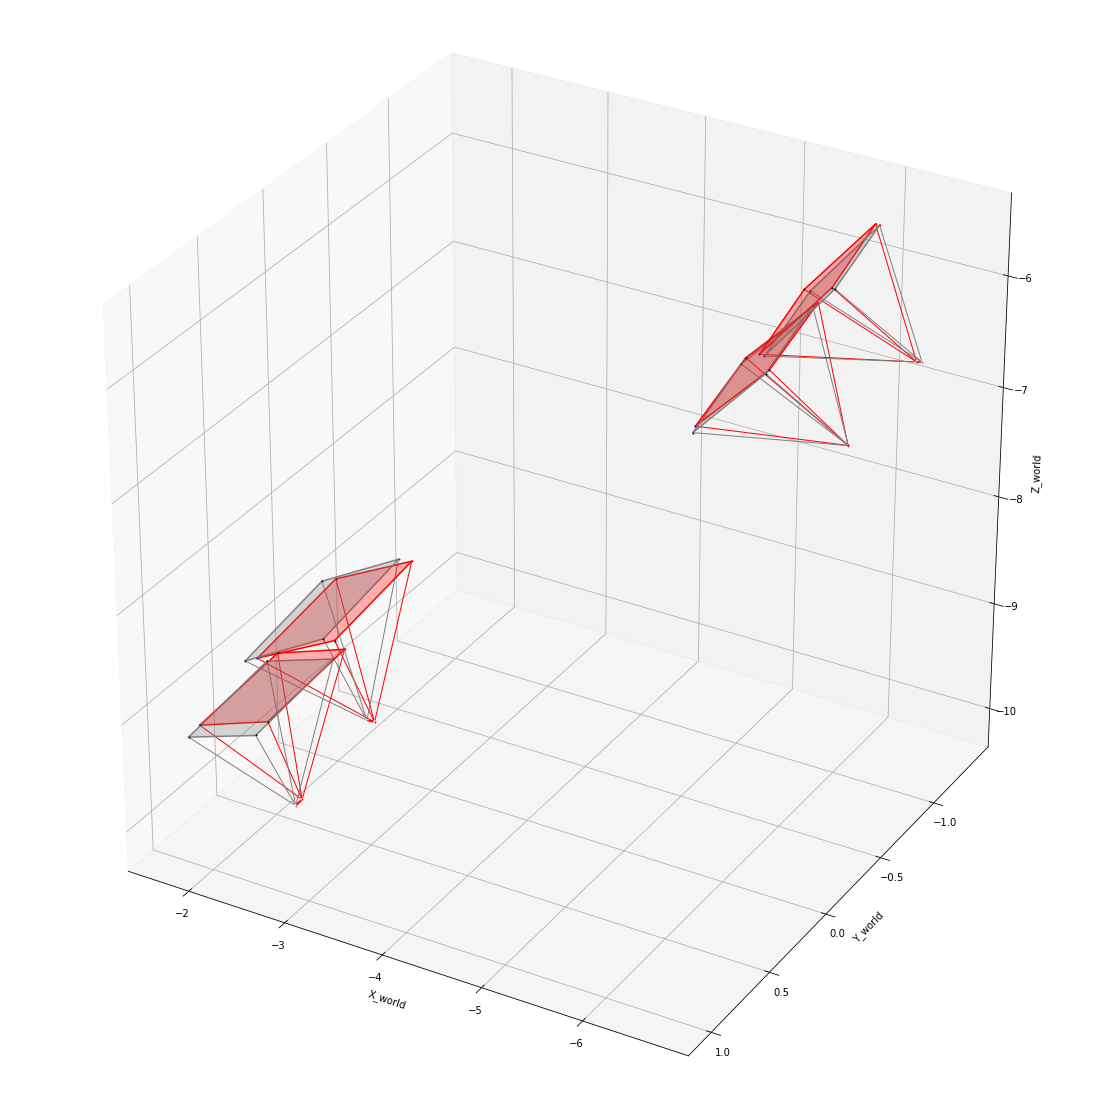

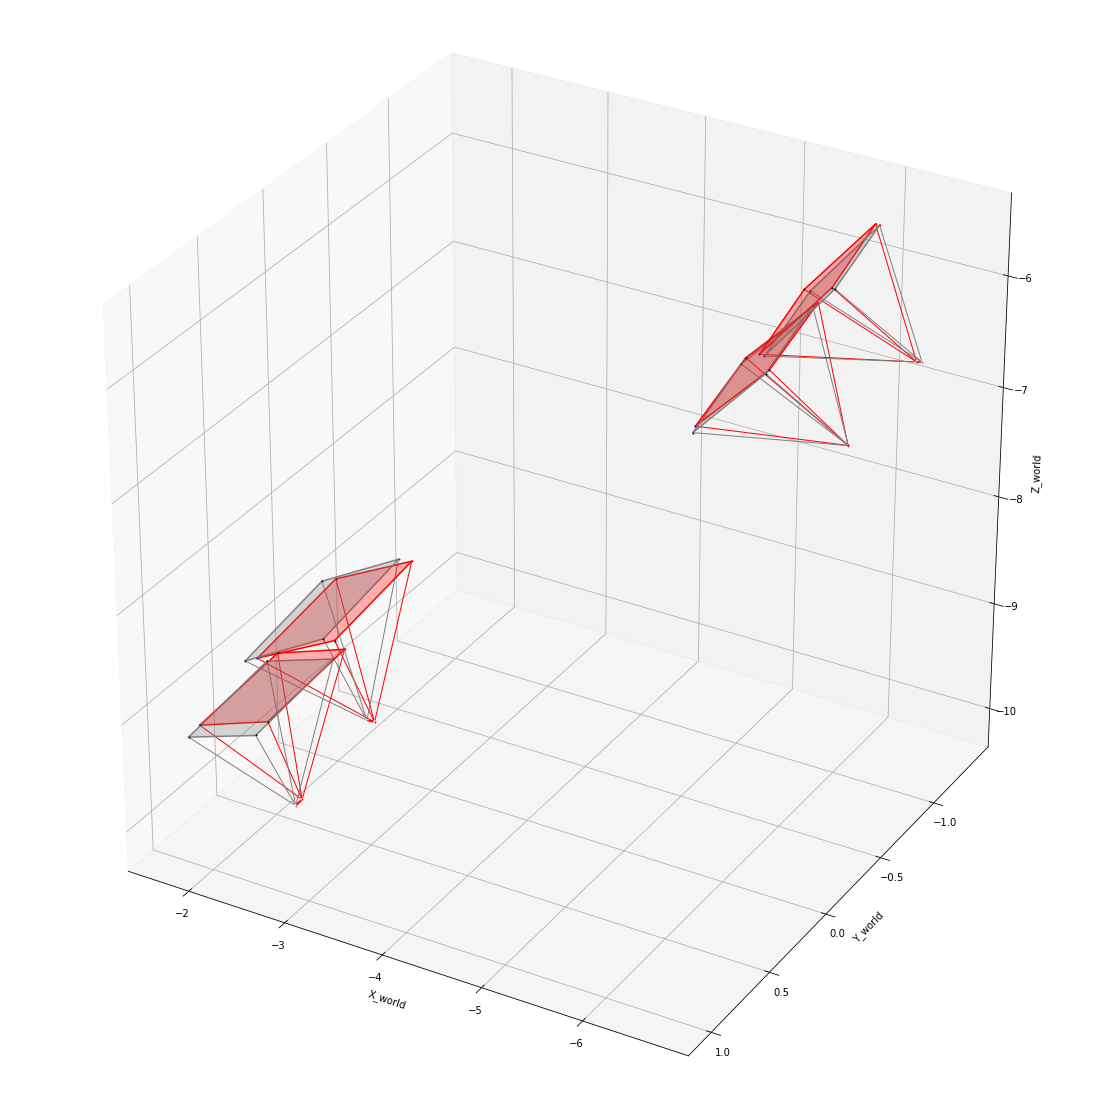

In [447]:
get_noise_camera_figure(cam_choices.to("cpu"), [noise_cam_choices.to("cpu")], draw_in_one_figure=True)

[<Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>,
 <Figure size 720x720 with 1 Axes>]

/home/kmuvcl/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/kmuvcl/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/kmuvcl/NVS/FastNeRFormer/notebook/../src/utils/utils.py:188: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


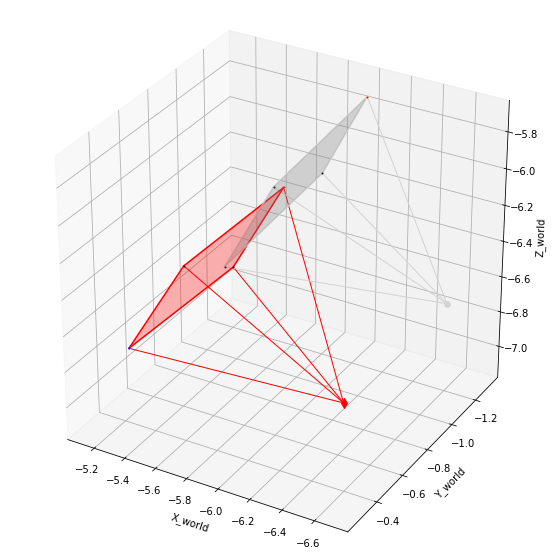

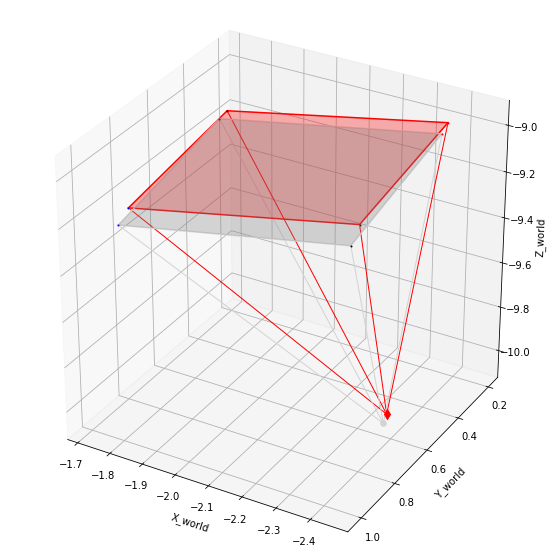

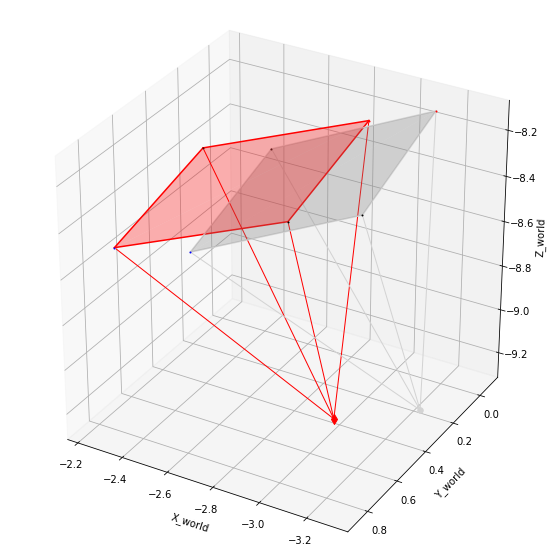

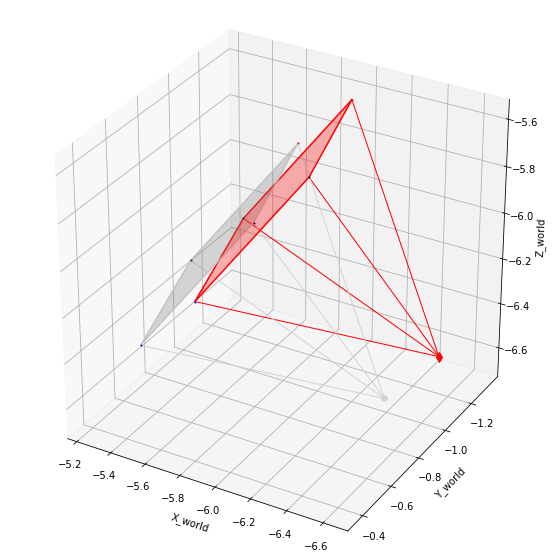

In [432]:
get_noise_camera_figure(cam_choices.to("cpu"), [cams_clone.to("cpu")], draw_in_one_figure=False)

In [467]:
str(pair_idxs[0])

'(0, 1)'

In [450]:
i, j = (0, 3)

result = correspondences["(%d, %d)"%(i, j)]
result = torch.stack((torch.tensor(result['i'], device="cuda"), 
                      torch.tensor(result['j'], device="cuda")), dim=0)

keypoint_idx = 50

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


p1_norm_im0_2d : tensor([[454.5330, 104.5630]], device='cuda:0')
p0_norm_im1_2d : tensor([[368.2952, 108.9897]], device='cuda:0')
tensor(457., device='cuda:0') tensor(105., device='cuda:0')
tensor(366., device='cuda:0') tensor(109., device='cuda:0')


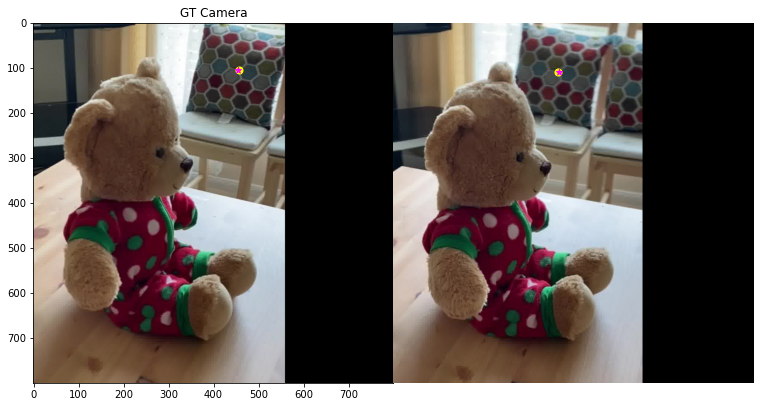

In [451]:
pair_rays = get_pair_rays((i, j), cam_choices.to("cuda"), 800, 800, result[:, [keypoint_idx]])
proejction_point = proj_ray_dist_loss_single_test(result[0, [keypoint_idx]], result[1, [keypoint_idx]], cam_choices.to("cuda"), (i, j), pair_rays, "test", 800, 800)

plt.figure(figsize=(10, 15))
plt.subplots_adjust(wspace=0, hspace=0.1, left=0, right=1, bottom=0, top=1)


keypoints_i = result[0]
keypoints_j = result[1]

i_x, i_y = keypoints_i[keypoint_idx]
print(i_x, i_y)
j_x, j_y = keypoints_j[keypoint_idx]
print(j_x, j_y)

plt.subplot(1, 2, 1)
plt.title("GT Camera")
plt.imshow(img_choices[i])
plt.scatter(i_x.item(), i_y.item(), c="yellow", s=50)
plt.scatter(proejction_point[0][0, 0].item(), proejction_point[0][0, 1].item(),  c="magenta", marker="*", s=40)

plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(img_choices[j])
plt.scatter(j_x.item(), j_y.item(), c="yellow", s=50)
plt.scatter(proejction_point[1][0, 0].item(), proejction_point[1][0, 1].item(), c="magenta", marker="*", s=40)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


p1_norm_im0_2d : tensor([[87.1086, 64.7552]], device='cuda:0')
p0_norm_im1_2d : tensor([[749.2737, 148.1782]], device='cuda:0')
(tensor([[87.1086, 64.7552]], device='cuda:0'), tensor([[749.2737, 148.1782]], device='cuda:0'))
tensor(457., device='cuda:0') tensor(105., device='cuda:0')
tensor(366., device='cuda:0') tensor(109., device='cuda:0')


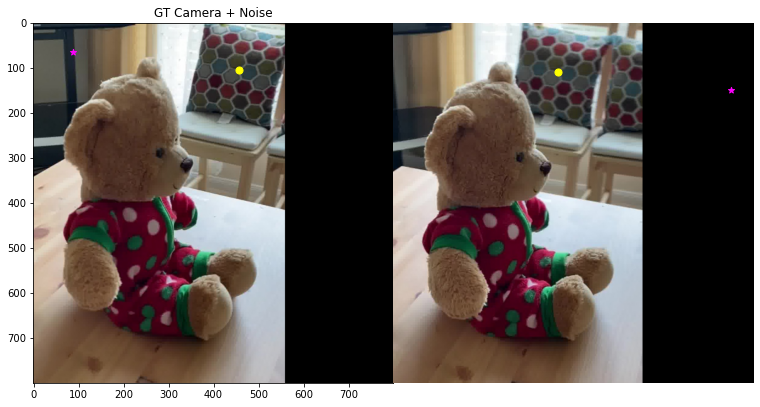

In [452]:
pair_rays = get_pair_rays((i, j), noise_cam_choices.to("cuda"), 800, 800, result[:, [keypoint_idx]])
proejction_point = proj_ray_dist_loss_single_test(result[0, [keypoint_idx]], result[1, [keypoint_idx]], noise_cam_choices.to("cuda"), (i, j), pair_rays, "test", 800, 800)
print(proejction_point)



plt.figure(figsize=(10, 15))
plt.subplots_adjust(wspace=0, hspace=0.1, left=0, right=1, bottom=0, top=1)


keypoints_i = result[0]
keypoints_j = result[1]

i_x, i_y = keypoints_i[keypoint_idx]
print(i_x, i_y)
j_x, j_y = keypoints_j[keypoint_idx]
print(j_x, j_y)

plt.subplot(1, 2, 1)
plt.title("GT Camera + Noise")
plt.imshow(img_choices[i])
plt.scatter(i_x.item(), i_y.item(), c="yellow", s=50)
plt.scatter(proejction_point[0][0, 0].item(), proejction_point[0][0, 1].item(),  c="magenta", marker="*", s=40)

plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(img_choices[j])
plt.scatter(j_x.item(), j_y.item(), c="yellow", s=50)
plt.scatter(proejction_point[1][0, 0].item(), proejction_point[1][0, 1].item(),  c="magenta", marker="*", s=40)

In [457]:
pair_rays["rays_o"].shape

torch.Size([2, 1, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([2, 1, 2])
p1_norm_im0_2d : tensor([[455.8418, 122.4796]], device='cuda:0', grad_fn=<IndexBackward>)
p0_norm_im1_2d : tensor([[366.6389,  90.3825]], device='cuda:0', grad_fn=<IndexBackward>)
torch.Size([353, 2])
tensor(457., device='cuda:0') tensor(105., device='cuda:0')
tensor(366., device='cuda:0') tensor(109., device='cuda:0')


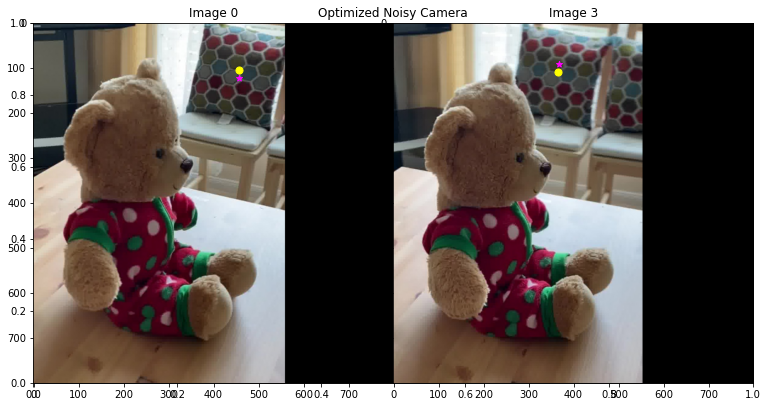

In [462]:
pair_rays = get_pair_rays((i, j), cams_clone.to("cuda"), 800, 800, result[:, [keypoint_idx]])
print(result[:, [keypoint_idx]].shape)
proejction_point = proj_ray_dist_loss_single_test(result[0, [keypoint_idx]], result[1, [keypoint_idx]], cams_clone.to("cuda"), (i, j), pair_rays, "test", 800, 800)

fig = plt.figure(figsize=(10, 5))
plt.title("Optimized Noisy Camera")

plt.subplots_adjust(wspace=0, hspace=0.1, left=0, right=1, bottom=0, top=1)


i_x, i_y = result[0, keypoint_idx]
j_x, j_y = result[1, keypoint_idx]
print(keypoints_i.shape)
#  = keypoints_i[keypoint_idx]
print(i_x, i_y)
#  = keypoints_j[keypoint_idx]
print(j_x, j_y)

ax = fig.add_subplot(1, 2, 1)
ax.set_title("Image %d"%i)
ax.imshow(img_choices[i])
ax.scatter(i_x.item(), i_y.item(), c="yellow", s=50)
ax.scatter(proejction_point[0][0, 0].item(), proejction_point[0][0, 1].item(),  c="magenta", marker="*", s=40)

ax = fig.add_subplot(1, 2, 2)
ax.set_title("Image %d"%j)
ax.imshow(img_choices[j])
ax.scatter(j_x.item(), j_y.item(), c="yellow", s=50)
ax.scatter(proejction_point[1][0, 0].item(), proejction_point[1][0, 1].item(),  c="magenta", marker="*", s=40)

In [372]:
# 이미지 페어 한 쌍에서 correspondences 사이의 projected ray distance를 계산함.
def proj_ray_dist_loss_single_test(kps0_list, kps1_list, camera, pair_idxs, pair_rays, mode, H, W, eps=1e-10,
                              proj_ray_dist_threshold=5.):
    
    assert kps0_list[:, 0].max() < W and kps1_list[:, 0].max() < W
    assert kps0_list[:, 1].max() < H and kps1_list[:, 1].max() < H

    rays_d = pair_rays["rays_d"]    # (2, correspondences, 3)
    rays_o = pair_rays["rays_o"]    # (2, 3)

    rays_d = rays_d / (rays_d.norm(p=2, dim=-1) + eps).unsqueeze(-1)  # unit vector
    
    rays_d_0, rays_d_1 = rays_d[0].unsqueeze(0), rays_d[1].unsqueeze(0)      # (1, correspondences, 3)
    rays_o_0, rays_o_1 = rays_o[0].unsqueeze(0), rays_o[1].unsqueeze(0)      # (1, correspondences, 3)

    rays_d_0 = rays_d_0 / (rays_d_0.norm(p=2, dim=-1)[:, :, None] + eps)
    rays_d_1 = rays_d_1 / (rays_d_1.norm(p=2, dim=-1)[:, :, None] + eps) 

    r0_r1 = torch.einsum(
        "ijk, ijk -> ij", 
        rays_d_0, 
        rays_d_1
    )
    # 첫 번째 이미지에서의 각 특징점들로 향하는 step 거리
    t0 = (
        torch.einsum(
            "ijk, ijk -> ij", 
            rays_d_0, 
            rays_o_0 - rays_o_1
        ) - r0_r1
        * torch.einsum(
            "ijk, ijk -> ij", 
            rays_d_1, 
            rays_o_0 - rays_o_1
        )
    ) / (r0_r1 ** 2 - 1 + eps)
    # 두 번째 이미지에서의 각 특징점들로 향하는 step 거리
    t1 = (
        torch.einsum(
            "ijk, ijk -> ij", 
            rays_d_1, 
            rays_o_1 - rays_o_0
        ) - r0_r1
        * torch.einsum(
            "ijk, ijk -> ij", 
            rays_d_0, 
            rays_o_1 - rays_o_0
        )
    ) / (r0_r1 ** 2 - 1 + eps)

    # 각 이미지에서의 특징점들의 포인트 X_A, X_B
    p0 = t0[:, :, None] * rays_d_0 + rays_o_0
    p1 = t1[:, :, None] * rays_d_1 + rays_o_1

    # 페어 이미지의 screen으로 projection
    # X_AB, X_BA
    p0_norm_im1 = camera.transform_points_screen(p0, eps=1., image_size=(H, W))[pair_idxs[1]].reshape(p0.shape)
    p1_norm_im0 = camera.transform_points_screen(p1, eps=1., image_size=(H, W))[pair_idxs[0]].reshape(p1.shape)

    # p0_norm_im1_2d = p0_norm_im1[:, :, :2] / \
    #     (p0_norm_im1[:, :, 2, None] + eps)
    # p1_norm_im0_2d = p1_norm_im0[:, :, :2] / \
    #     (p1_norm_im0[:, :, 2, None] + eps)

    p0_norm_im1_2d = p0_norm_im1[:, :, :2]
    p1_norm_im0_2d = p1_norm_im0[:, :, :2]
        
    # Chirality check: remove rays behind cameras
    # First, flatten the correspondences
    # Find indices of valid rays
    valid_t0 = (t0 > 0).flatten()
    valid_t1 = (t1 > 0).flatten()
    valid = torch.logical_and(valid_t0, valid_t1)

    p1_norm_im0_2d, kps0_list = p1_norm_im0_2d[0, valid], kps0_list[valid]
    p0_norm_im1_2d, kps1_list = p0_norm_im1_2d[0, valid], kps1_list[valid]
    print("p1_norm_im0_2d :", p1_norm_im0_2d)
    print("p0_norm_im1_2d :", p0_norm_im1_2d)
    return p1_norm_im0_2d, p0_norm_im1_2d
    # Second, select losses that are valid
    loss0_list = (
        (p1_norm_im0_2d - kps0_list) ** 2
    ).sum(-1).flatten()
    loss1_list = (
        (p0_norm_im1_2d - kps1_list) ** 2
    ).sum(-1).flatten()

    if mode == "train":
        loss0_valid_idx = torch.logical_and(
            loss0_list < proj_ray_dist_threshold, 
            torch.isfinite(loss0_list)
        )
        loss1_valid_idx = torch.logical_and(
            loss1_list < proj_ray_dist_threshold, 
            torch.isfinite(loss1_list)
        )

        loss0 = loss0_list[loss0_valid_idx].mean()
        loss1 = loss1_list[loss1_valid_idx].mean()

        num_matches = torch.logical_and(
            loss0_valid_idx, loss1_valid_idx
        ).float().sum().item() 
        
        return 0.5 * (loss0 + loss1), num_matches
        
    else:
        loss0_invalid_idx = torch.logical_or(
            loss0_list > proj_ray_dist_threshold,
            torch.logical_not(torch.isfinite(loss0_list))
        )
        loss0_list[loss0_invalid_idx] = proj_ray_dist_threshold
        loss0 = loss0_list.mean()

        loss1_invalid_idx = torch.logical_or(
            loss1_list > proj_ray_dist_threshold,
            torch.logical_not(torch.isfinite(loss1_list))
        )
        loss1_list[loss1_invalid_idx] = proj_ray_dist_threshold
        loss1 = loss1_list.mean()

        return 0.5 * (loss0 + loss1), None

In [343]:
delta_T

Parameter containing:
tensor([[-0.0987, -0.0903, -0.0329],
        [ 0.0000,  0.0000,  0.0000],
        [-0.0449, -0.0020,  0.1133],
        [ 0.1044,  0.1187, -0.0902]], device='cuda:0', requires_grad=True)

In [344]:
delta_R

tensor([[[ 0.9976,  0.0106, -0.0680],
         [-0.0104,  0.9999,  0.0040],
         [ 0.0680, -0.0033,  0.9977]],

        [[ 1.0000,  0.0000,  0.0000],
         [ 0.0000,  1.0000,  0.0000],
         [ 0.0000,  0.0000,  1.0000]],

        [[ 0.9995,  0.0151, -0.0283],
         [-0.0154,  0.9998, -0.0128],
         [ 0.0281,  0.0132,  0.9995]],

        [[ 0.9995, -0.0189,  0.0269],
         [ 0.0193,  0.9997, -0.0144],
         [-0.0266,  0.0149,  0.9995]]], device='cuda:0',
       grad_fn=<TransposeBackward0>)

In [133]:
target, srcs = data_to_frame_test(data_frame, 3)

In [103]:
print(srcs.keys())
print(srcs["camera"])

dict_keys(['rgb', 'mask', 'camera', 'camera_obj', 'noise_camera', 'noise_camera_obj'])
{'w2c': tensor([[[ 0.5140, -0.4504, -0.7301,  0.0000],
         [ 0.4076, -0.6207,  0.6698,  0.0000],
         [-0.7548, -0.6418, -0.1355,  0.0000],
         [-1.0374,  0.8149, 10.5931,  1.0000]],

        [[ 0.9358, -0.1731, -0.3070,  0.0000],
         [ 0.1773, -0.5213,  0.8347,  0.0000],
         [-0.3045, -0.8356, -0.4572,  0.0000],
         [-0.9133,  0.9266, 10.2719,  1.0000]],

        [[ 0.8152,  0.3207,  0.4823,  0.0000],
         [-0.2546, -0.5497,  0.7956,  0.0000],
         [ 0.5203, -0.7714, -0.3665,  0.0000],
         [-0.5702,  0.7911,  9.0564,  1.0000]]]), 'c2w': tensor([[[ 0.5140,  0.4076, -0.7548,  0.0000],
         [-0.4504, -0.6207, -0.6418,  0.0000],
         [-0.7301,  0.6698, -0.1355,  0.0000],
         [ 8.6337, -6.1670,  1.1752,  1.0000]],

        [[ 0.9358,  0.1773, -0.3045,  0.0000],
         [-0.1731, -0.5213, -0.8356,  0.0000],
         [-0.3070,  0.8347, -0.4572,  0.000

In [21]:
tgt_cam = target["camera"]
src_cams = srcs["camera"]

In [34]:
point_cloud = data_frame.sequence_point_cloud.points_list()[0]
print(point_cloud.shape)

torch.Size([980001, 3])


In [43]:
proj_points = tgt_cam.transform_points_screen(point_cloud, image_size=(800, 800))[0]
print(proj_points.shape)

torch.Size([3])


torch.Size([980001, 3])
torch.Size([980001, 3])
torch.Size([980001, 3])
torch.Size([980001, 3])


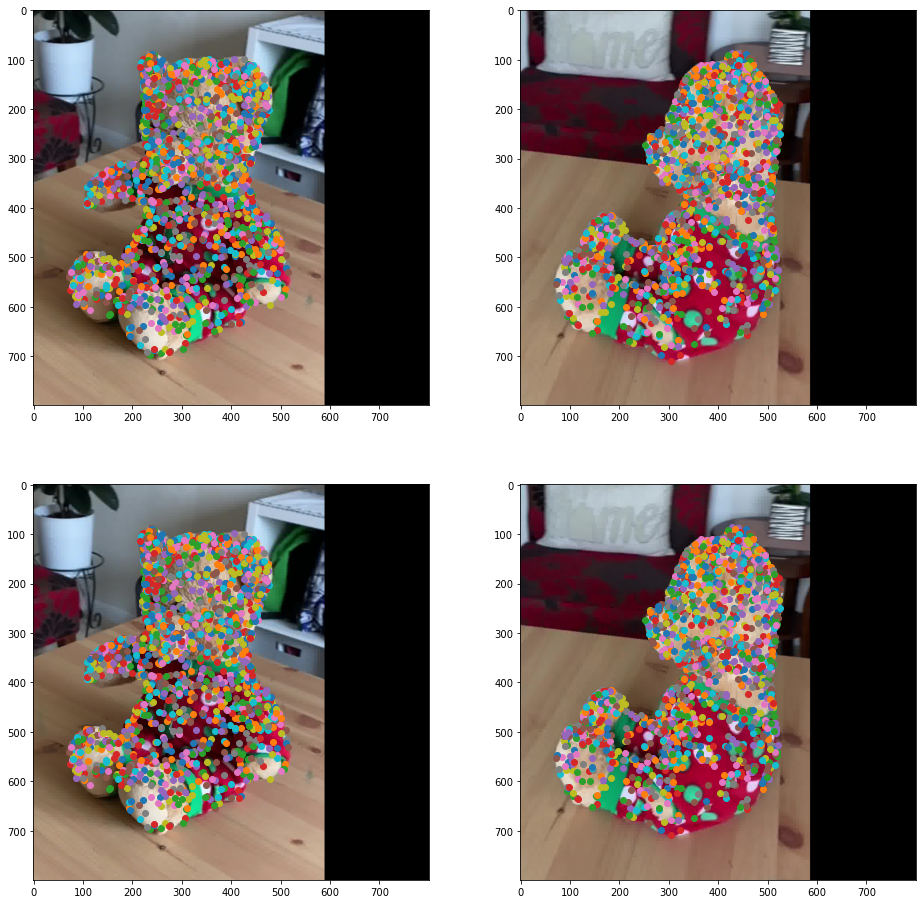

In [209]:
plt.figure(figsize=(16, 16))

plt.subplot(2, 2, 1)

img = target["rgb"].numpy().transpose(1, 2, 0)
plt.imshow(img)

proj_points = tgt_cam.transform_points_screen(point_cloud, image_size=(800, 800))
print(proj_points.shape)
for point in proj_points[::600][:]:
    x = point[0].item()
    y = point[1].item()

    plt.scatter(x, y)
####################################
plt.subplot(2, 2, 2)

img = srcs["rgb"][0].numpy().transpose(1, 2, 0)
plt.imshow(img)

proj_points = src_cams.transform_points_screen(point_cloud, image_size=(800, 800))[0]
print(proj_points.shape)

for point in proj_points[::600]:
    x = point[0].item()
    y = point[1].item()

    plt.scatter(x, y)
    
##################################################################

plt.subplot(2, 2, 3)

img = target["rgb"].numpy().transpose(1, 2, 0)
plt.imshow(img)

# proj_points = tgt_cam.transform_points_screen(point_cloud, image_size=(800, 800))
proj_points = project_world_to_screen(target["camera"], point_cloud)
print(proj_points.shape)
for point in proj_points[::600][:]:
    x = point[0].item()
    y = point[1].item()

    plt.scatter(x, y)
####################################
plt.subplot(2, 2, 4)

img = srcs["rgb"][0].numpy().transpose(1, 2, 0)
plt.imshow(img)

# proj_points = src_cams.transform_points_screen(point_cloud, image_size=(800, 800))[0]
proj_points = project_world_to_screen(srcs["camera"], point_cloud)[0]
print(proj_points.shape)

for point in proj_points[::600]:
    x = point[0].item()
    y = point[1].item()

    plt.scatter(x, y)